In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()

# Boundary Layer Solver

This section will develop a numerical method for solving the boundary layer momentum integral equation using Pohlhausen velocity profiles.

## Momentum integral equation

In the boundary layer portion of the course we derived the governing equations for a boundary layer using the concept of a velocity profile 

$$u = u_e(x) f(\eta), \quad \eta=\frac y{\delta(x)}$$

where $u_e$ is the local free stream velocity and $\delta$ is the boundary layer thickness. Note that $x$ is the distance along the wall from the leading edge and $y$ is the distance from the wall.

---
<img src="resources/graphics4.png" width="400">

---

Integrating the Prandtl momentum equation through the boundary layer thickness resulted in the **momentum integral equation**

$$ \frac 12 c_f = \frac{u_e'}{u_e}(\delta_1+2\delta_2)+\delta_2' $$

This equation balances the local wall friction with the change in the boundary layer profile properties. The tick mark indicates a derivative, ie $u_e'=\frac{du_e}{dx}$. 

** The goal is to use the momentum equation to determine how the boundary layer develops, predicting the friction drag and the point of separation. **

The velocity $u_e$ (and $u_e'$) is considered to be prescribed by the potential flow solution, but there are still too many unknowns. We need to choose a profile to develop this further...

## Pohlhausen profile

The Pohlhausen profile is used to describe a **laminar** velocity profile exposed to external pressure gradients. The profile is defined as

$$ \frac u {u_e} = f(\eta,\lambda) = P_F(\eta)+\lambda P_G(\eta) $$

where $\lambda$ is the *shape factor*, given by
$$ \lambda = \frac {\delta^2}\nu u_e'$$

and the profile shapes are defined by

- $P_F = 2\eta-2\eta^3+\eta^4$ is the flat plate profile
- $P_G = \frac\eta 6 (1-\eta)^3$ is the modification for pressure gradients

These can be easly defined using a set of python functions

In [13]:
from matplotlib import pyplot
%matplotlib notebook
import numpy

def pohlF(eta): return 2*eta-2*eta**3+eta**4
def pohlG(eta): return eta/6*(1-eta)**3

def pohlPlot(lam):
    pyplot.figure(figsize=(5,5))
    pyplot.xlabel(r'$u/u_e$', fontsize=24)
    pyplot.ylabel(r'$y/\delta$', fontsize=24)
    eta = numpy.linspace(0.0,1.0)
    pyplot.plot(pohlF(eta),eta, ls='--', label=r'$f(0)$')
    pyplot.plot(pohlF(eta)+lam*pohlG(eta),eta, lw=2, label=r'$f(\lambda)$')
    pyplot.legend(loc='upper left', fontsize=16)

Change $\lambda$ below to see its effect on the profile shape.

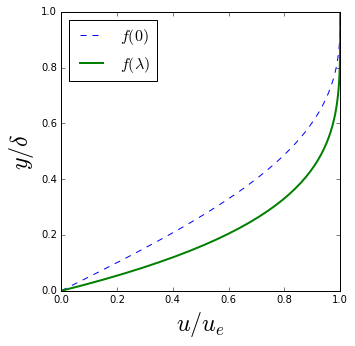

In [3]:
pohlPlot(lam=12)

##### Quiz

What value of $\lambda$ denotes separated flow?

1. $\lambda$<-12
1. $\lambda$=0
1. $\lambda$>12

---

Using the Pohlhausen profile, the factors in the momentum integral equation can be defined as functions of $\lambda$

- $\frac{\delta_1}\delta = \int_0^1 (1-f) d\eta = \frac3{10}-\lambda\frac1{120}$


- $F=\frac{\delta_2}\delta = \int_0^1 f(1-f) d\eta = \frac{37}{315}-\lambda\frac1{945}-\lambda^2\frac1{9072}$


- $\frac 12 c_f Re_\delta =f'_0= 2+\lambda\frac1{6}$

where $Re_\delta = \frac{u_e\delta}\nu$ is the local boundary layer Reynolds number. 

I've implemented these in the `BoundaryLayer` module (which I'll nickname `bl`) as `disp_ratio`, `mom_ratio`, and `df_0`:

Help on module BoundaryLayer:

NAME
    BoundaryLayer - Solve boundary layer problems using Pohlhausen's method

DESCRIPTION
    This module holds routines to determine the evolution of a boundary layer
    in a varying external flow assuming a Pohlhausen velocity profile.
    
    Methods:
        disp_ratio, mom_ratio, df_0
        march, sep
    
    Imports: numpy, cumtrapz & odeint from scipy.integrate

FUNCTIONS
    df_0(lam)
        # wall derivative
    
    disp_ratio(lam)
        # displacement thickness ratios
    
    march(s, u_s, nu, thwaites=False)
        March the boundary layer momentum integral equation
        
        Notes:
        Output array values after separation(lam<-12) are meaningless.
        
        Inputs:
        s   -- array of distances along the boundary layer; must be positive and increasing
        u_s -- array of external velocities; must be positive
        nu  -- kinematic viscosity; must be scalar
        thwaites -- Thwaites approximate meth

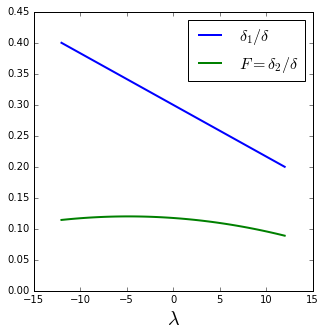

In [4]:
import BoundaryLayer as bl

pyplot.figure(figsize=(5,5))
pyplot.xlabel(r'$\lambda$', fontsize=20)
lam = numpy.linspace(-12,12)
pyplot.plot(lam,bl.disp_ratio(lam), lw=2, label=r'$\delta_1/\delta$')
pyplot.plot(lam,bl.mom_ratio(lam), lw=2, label=r'$F=\delta_2/\delta$')
pyplot.ylim(0,)
pyplot.legend(loc='upper right',fontsize=16)

help(bl)

## Pressure gradient

Scaling the integral momentum equation by $\delta_2 u_e/\nu$ we have

$$\frac{\delta_2 u_e}\nu \frac{d\delta_2}{dx} = g(\lambda) $$

where the right hand side is a function of $\lambda$ only:

$$ g = Ff'_0-F\lambda\left(\frac{\delta_1}{\delta}+2F\right) $$

When the pressure gradient is zero this ODE simplifies to the flat plate ODE we did in lecture. But what happens to the boundary layer development when we have strong pressure gradients?

For example, for any body with finite thickness the boundary layer will begin at the stagnation point where $u_e=0$ at the front of the body.

<img src="resources/stagnation.png" width="400">

Since $u_e=0$ the momentum equation becomes

$$ \frac{\delta_2 0}\nu \frac{d\delta_2}{dx} = 0 = g(\lambda_0) $$

at a stagnation point. Therefore the root of $g$ defines a stagnation point initial condition $\lambda_0$. We can find this using a root-finding function like [`fsolve`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fsolve.html) :

lambda_0 = 7.052
check: g(lambda_0) = 0


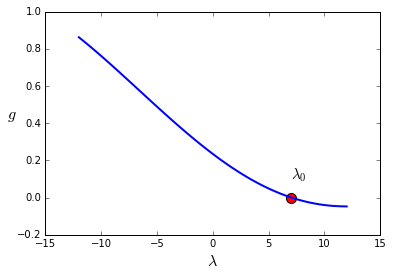

In [5]:
def g(lam):
    F = bl.mom_ratio(lam)
    return F*(bl.df_0(lam)-lam*(bl.disp_ratio(lam)+2.*F))

from scipy.optimize import fsolve
lam0 = fsolve(g,0)[0]
print('lambda_0 = '+'%.3f'%lam0)
print('check: g(lambda_0) = '+'%.3g'%g(lam0))

pyplot.plot(lam,g(lam), lw=2)
pyplot.xlabel(r'$\lambda$', fontsize=16)
pyplot.ylabel(r'$g$', fontsize=16, rotation=0)
pyplot.scatter(lam0,0, s=100, c='r')
pyplot.text(lam0,0.1, r'$\lambda_0$',fontsize=15)


---

##### Quiz

Given that $\frac{d\delta_2}{dx}\propto g$, what will happen if we have a strong pressure gradient such that $\lambda>\lambda_0$?

1. Flat plate boundary layer flow.
1. The boundary layer will shrink.
1. The boundary layer will separate.

---

## Thwaites solution method

Thwaites approximated $g$ as

$$ g \approx \tilde g = 0.225-3 F^2\lambda $$

Let's check this approximation

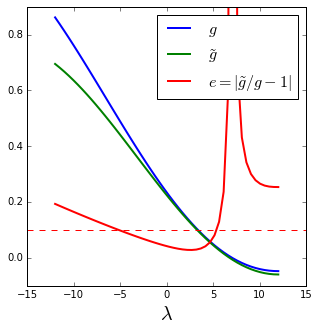

In [6]:
pyplot.figure(figsize=(5,5))
pyplot.xlabel(r'$\lambda$', fontsize=20)
def tg(lam): return 0.225-3*bl.mom_ratio(lam)**2*lam
lam = numpy.linspace(-12,12)
pyplot.plot(lam,g(lam), lw=2, label=r'$g$')
pyplot.plot(lam,tg(lam), lw=2, label=r'$\tilde{g}$')
pyplot.plot(lam,abs(tg(lam)/g(lam)-1), lw=2, label=r'$e=|\tilde{g}/g-1|$')
pyplot.axhline(0.1,ls='--',c='r')
pyplot.ylim(-0.1,0.9)
pyplot.legend(fontsize=16)

We can see that this approximation is within 10% when the pressure gradient is small ($-5>\lambda>5$) and has the right trend for the rest of the range.

Using his approximation, Thwaites was able to integrate the momentum equation into the form 

$$ \delta^2_2(x) =\frac{0.45\nu}{u^6_e(x)}\int^x_0 u_e^5(\xi) d\xi $$

where $\xi$ is the variable of integration. 

This can be implemented very easily in python. We simply integrate over a velocity array `u_e` with `x` as the corresponding distance along the boundary layer:

```python
from scipy.integrate import cumtrapz
delta2 = numpy.sqrt(0.45*nu/u_e**6*cumtrap(u_e**5*,x,initial=0))
```

where [`cumtrapz`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.cumtrapz.html) is the cumulative version of trapz. 

##### Quiz

Assuming the same array size $N$, how long will it take to solve boundary layer equation compared to the vortex panel equation?

1. Boundary layer will take **less** time
1. Boundary layer layer will take **the same** amount of time
1. Boundary layer will take **more** time

---

## Full integral equation

The approximation $\tilde g$ isn't perfect; it is $20\%$ off near the separation point and doesn't have the same stagnation point condition. Let's try to solve the exact momentum equation numerically and then compare to Thwaites. 

Starting from the scaled momentum equation, we just need to pull $\delta_2$ into the derivative to get

$$
\frac{d\delta_2^2}{dx} = \frac {2\nu g(\lambda)}{u_e(x)} 
$$

##### Quiz

The rate of change of $\delta_2^2$ depends on which unknowns?

1. $\lambda$
1. $u_e,\nu$
1. $\delta_2^2$

---

Therefore, this equation is an ODE for $\delta_2^2$ that we can integrate numerically (using `numpy.integrate.odeint`). We start at the initial condition defined above and __march__ one step at a time along the boundary layer, so I've called the function `BoundaryLayer.march`.

In [7]:
help(bl.march)

Help on function march in module BoundaryLayer:

march(s, u_s, nu, thwaites=False)
    March the boundary layer momentum integral equation
    
    Notes:
    Output array values after separation(lam<-12) are meaningless.
    
    Inputs:
    s   -- array of distances along the boundary layer; must be positive and increasing
    u_s -- array of external velocities; must be positive
    nu  -- kinematic viscosity; must be scalar
    thwaites -- Thwaites approximate method flag (default=False)
    
    Outputs:
    delta2 -- momentum thickness array
    lam   -- shape parameter array
    iSep  -- separation index
    
    Examples:
    s = numpy.linspace(0,numpy.pi,16)        # define distance array
    u_s = 2*numpy.sin(s)                     # define external velocity (circle example)
    delta2,lam,iSep = march(s,u_s,nu=1e-5)   # march along to the point of separation



Note that I've included an option `thwaites` to use the approximate method instead. Let's test these two against the flat plate solution:

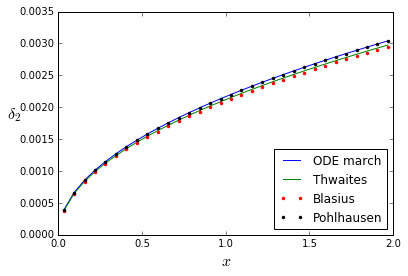

In [8]:
N=32; nu=1e-5                          # number of steps and k.visc.
x = numpy.linspace(1./N,2-1./N,N)      # distance from leading edge
u_e = numpy.ones_like(x)               # flat plate (uniform) external velocity
delta2_m,_,_ = bl.march(x,u_e,nu)      # momentum equation vs thwaites
delta2_t,_,_ = bl.march(x,u_e,nu,thwaites=True)

pyplot.plot(x,delta2_m,label='ODE march')
pyplot.plot(x,delta2_t,label='Thwaites')
pyplot.plot(x,0.664*numpy.sqrt(nu*x),'r.',label='Blasius')
pyplot.plot(x,0.685*numpy.sqrt(nu*x),'k.',label='Pohlhausen')
pyplot.ylabel(r'$\delta_2$', fontsize=16,rotation=0)
pyplot.xlabel(r'$x$', fontsize=16)
pyplot.legend(loc='lower right')

`ODE march` collapses to the flat plate Pohlhausen, while Thwaites tuned his results to match Blasius.

Of course, there was no point in doing this numerically if we only wanted the flat plate solution...

##### Your turn #4

The function `wedge_u_e` gives the potential flow velocity on the surface of a point-forward wedge

$$ u_e = U x^{\beta/(2-\beta)}$$

where $\pi\beta$ is the wedge angle and $U=1$ is the free stream velocity. Use it to complete the following coursework for $\beta=1/16,1/8,1/4,1/2$:

- ** Plot and Compare ** the predicted wedge momentum thickness againt the Blasius flat plate solution for $x=0\ldots10$
- ** Complete ** the $c_f$ function for the local fiction coefficient 
- ** Plot and Compare ** the predicted friction coefficients against the flat plate solution
- ** Complete ** the $C_F$ function for the integrated friction coefficient
$$C_F = \frac{\int_0^L \tau_w dx}{\frac 12 \rho U^2 L }$$
where 
$$ \tau_w = \frac 12 c_f \rho u_e^2 $$
- ** Plot and Compare ** to the flat plate solution 

---

##### Solution #4

The momentum thickness.

<IPython.core.display.Javascript object>


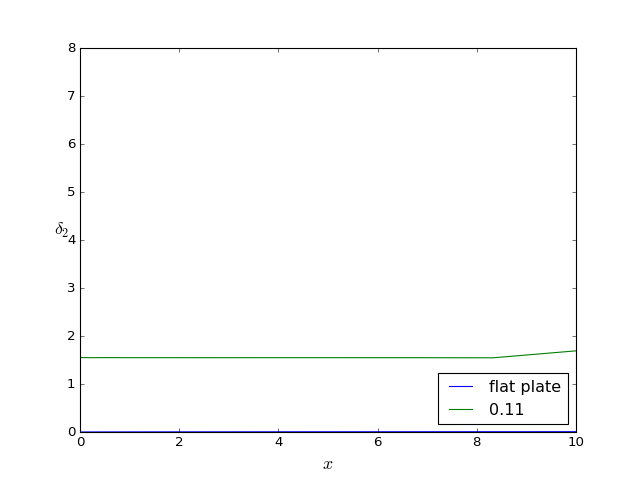

[ 7.05300185  6.20168225  4.99922817  4.14020366  3.51533248  3.06361762
  2.72727855  2.46383277  2.2638867   2.10911733  1.98735716  1.89025186
  1.81441714  1.7563492   1.71192342  1.67708053  1.64944583  1.62773343
  1.61080687  1.59764937  1.58746688  1.57951563  1.57307263  1.56765355
  1.56369333  1.56070059  1.558059    1.55602948  1.55440607  1.55309446
  1.55206193  1.55160792  1.55121503  1.55043448  1.54989117  1.54937264
  1.54919191  1.54933812  1.5497323   1.54982346  1.54935716  1.54907136
  1.54873569  1.54873762  1.5491123   1.54965706  1.54981861  1.54955528
  1.54940911  1.54912578  1.54885275  1.54887409  1.54894002  1.54862183
  1.54843748  1.54821889  1.54817279  1.54838433  1.54857287  1.54858843
  1.54828637  1.54790532  1.54571739  1.6909166 ]


In [15]:
N=64; nu=1e-5
x = numpy.logspace(-4,1,N)
beta_list = [0.11]

def wedge_u_e(x, beta): 
    return x**(beta/(2-beta))

pyplot.plot(x,0.664*numpy.sqrt(nu*x),label='flat plate')

for b in beta_list:
    delta2, lam, iSep = bl.march(x,wedge_u_e(x, b),nu)
    pyplot.plot(x,lam,label=b)
    print(lam)

pyplot.ylabel(r'$\delta_2$', fontsize=16, rotation=0)
pyplot.xlabel(r'$x$', fontsize=16)
pyplot.legend(loc='lower right')


The local friction coefficient.

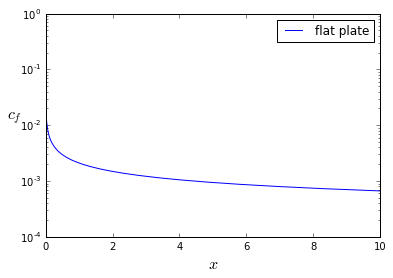

In [10]:
def c_f(u_e,delta,lam,nu):
    return # your code here

pyplot.semilogy(x,0.664*numpy.sqrt(nu/x),label='flat plate')

# your code here

pyplot.legend(loc='upper right')
pyplot.ylabel(r'$c_f$', fontsize=16, rotation=0)
pyplot.xlabel(r'$x$', fontsize=16)

The global friction coefficient.

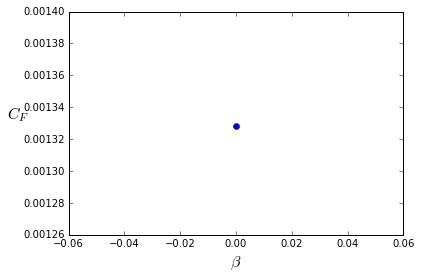

In [11]:
def C_F(u_e,delta,lam,nu,x):
    dx = numpy.gradient(x) # spacing
    L = x[-1]              # length
    return # your code here

pyplot.plot(0,[1.328*numpy.sqrt(nu/x[-1])],'o')

# your code here

pyplot.ylabel(r'$C_F$', fontsize=16, rotation=0)
pyplot.xlabel(r'$\beta$', fontsize=16)